In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

import os
import cv2
import sys
import random
import warnings
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Activation, Add, multiply, add, concatenate, LeakyReLU, ZeroPadding2D, UpSampling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

IMG_HEIGHT = 400
IMG_WIDTH = 400
IMG_CHANNEL = 1

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [ ]:
from PIL import Image

In [ ]:
def AttnBlock2D(x, g, inter_channel, data_format='channels_first'):

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)

    f = Activation('relu')(add([theta_x, phi_g]))

    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([x, rate])

    return att_x


def attention_up_and_concate(down_layer, layer, data_format='channels_first'):

    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]

    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)
    layer = AttnBlock2D(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[3]], axis=3))

    concate = my_concat([up, layer])
    return concate

# Attention U-Net
def att_unet(img_w, img_h, n_label, data_format='channels_first'):
    inputs = Input((IMG_CHANNEL, img_w, img_h))
    x = inputs
    depth = 4
    features = 32
    skips = []
    for i in range(depth):

        # ENCODER
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format='channels_first')(x)
        features = features * 2

    # BOTTLENECK
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    # DECODER
    for i in reversed(range(depth)):
        features = features // 2
        x = attention_up_and_concate(x, skips[i], data_format=data_format)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    conv6 = Conv2D(n_label, (1, 1), padding='same', data_format=data_format)(x)
    conv7 = Activation('sigmoid')(conv6)

    model = Model(inputs=inputs, outputs=conv7)

    return model

model = att_unet(IMG_WIDTH, IMG_HEIGHT, n_label=1)

2023-01-02 16:06:33.882846: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
model.summary()

In [ ]:
from keras.models import load_model

model.load_weights("../input/m2model/m2.h5")

In [ ]:
img_path=r"../input/dxameta/DXAmeta"

In [ ]:
dir=os.listdir(img_path)

In [ ]:
X_pre_seg = np.zeros((len(dir), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)
X_raw = np.zeros((len(dir), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
X_raw.shape

(199, 400, 400, 3)

In [ ]:
i = 0
for jfile in dir:
    filename = img_path + "/" + jfile
    image_raw = imread(filename)

    image = Image.open(filename)
    image = image.convert('L')

    RawImage = np.array(image)
    RawImage = np.expand_dims(resize(RawImage, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)

    #image_raw = np.array(image_raw)
    #image_raw = np.expand_dims(resize(image_raw, (IMG_HEIGHT, IMG_WIDTH,3), mode='constant', preserve_range=True), axis=-1)

    X_pre_seg[i] = RawImage
    X_raw[i] = image_raw
    i = i+1

In [ ]:
X_pre_seg = np.rollaxis(X_pre_seg, 3, 1)
print(X_pre_seg.shape)

(199, 1, 400, 400)


In [ ]:
pred_val = model.predict(X_pre_seg.astype(np.float16), verbose=1)

2023-01-02 16:07:15.521466: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


7/7 [==============================] - 213s 29s/step


In [ ]:
pred_val = np.rollaxis(pred_val, 3, 1)
pred_val = np.rollaxis(pred_val, 3, 2)
pred_val = np.swapaxes(pred_val, 1, 2)
pred_val.shape

(199, 400, 400, 1)

In [ ]:
X_crop = np.zeros((len(dir), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)

In [ ]:
for i in range(0,len(pred_val)):
    mask = pred_val[i][:,:,0]
    for m in range(0,len(mask)):
        for n in range(0,len(mask[m])):
            if mask[m][n] > 0.4:
                mask[m][n] = 1
            else:
                mask[m][n] = 0
    image = X_raw[i]

    for j in range(0,3):
        #print(image[:,:,j].shape)
        #print(mask.shape)
        image[:,:,j] = np.multiply(image[:,:,j],mask)

    X_crop[i] = image

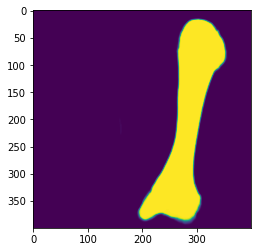

In [ ]:
plt.imshow(pred_val[5])

In [ ]:
test = Image.fromarray(X_crop[3][:,200:,:])

In [ ]:
from PIL import ImageEnhance

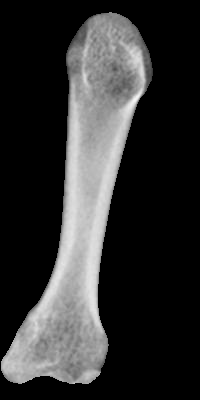

In [ ]:
enh_con = ImageEnhance.Contrast(test)
contrast = 1
image_contrasted = enh_con.enhance(contrast)
image_contrasted

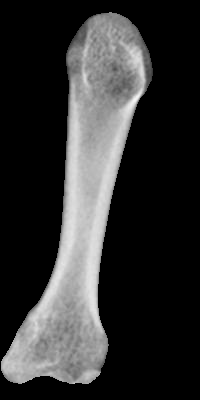

In [ ]:
enh_col = ImageEnhance.Color(test)
color = 3
image_colored = enh_col.enhance(color)
image_colored

In [ ]:
mkdir out

In [ ]:
out_p=r"./out"


In [ ]:
for i in range(0,len(X_crop)):


    outpath = out_p + "/" + dir[i]

    plt.imsave(outpath,X_crop[i])

In [ ]:
X_crop.shape

(697, 400, 400, 3)

In [ ]:
import os
import zipfile
import datetime

def file2zip(packagePath, zipPath):

    zip = zipfile.ZipFile(zipPath, 'w', zipfile.ZIP_DEFLATED)
    for path, dirNames, fileNames in os.walk(packagePath):
        fpath = path.replace(packagePath, '')
        for name in fileNames:
            fullName = os.path.join(path, name)
            name = fpath + '\\' + name
            zip.write(fullName, name)
    zip.close()


if __name__ == "__main__":

    packagePath = '/working/out'
    zipPath = '/working/output.zip'
    if os.path.exists(zipPath):
        os.remove(zipPath)
    file2zip(packagePath, zipPath)
    print("complated")
    print(datetime.datetime.utcnow())